# What is the best destination for student exchange?

All available student exchange sites will be analysed for weather characteristics to determine which location has a similar climate to ours.

## Installing required libraries

In [43]:
%%capture
%pip install openmeteo-requests
%pip install requests-cache retry-requests numpy pandas
%pip install pprint
%pip install ipympl, ipywidgets

## Preparing university list

In [44]:
import urllib.request
import json
import urllib.parse
import pprint

def get_uni_data(uni):
  with urllib.request.urlopen("https://nominatim.openstreetmap.org/search?format=json&q=" + urllib.parse.quote_plus(uni['name'])) as url:
    data = json.loads(url.read().decode())
  if len(data) == 0: # University not found - but the names often contain city name at the end.
    with urllib.request.urlopen("https://nominatim.openstreetmap.org/search?format=json&q=" + urllib.parse.quote_plus(uni['name'].split()[-1])) as url:
      data = json.loads(url.read().decode())
  data = data[0]
  uni['lat'] = float(data['lat'])
  uni['lon'] = float(data['lon'])
  uni['country'] = data['display_name'].split(',')[-1].lstrip()

unis = [
  {'name': 'Politechnika Warszawska'},
  {'name': 'Fachhochschule Salzburg'},
  {'name': 'Johannes Kepler Universität Linz'},
  {'name': 'Katholieke Universiteit Leuven'},
  {'name': 'Universiteit Antwerpen'},
  {'name': 'Shumen University "Konstantin Preslavski"'},
  {'name': 'University of Nicosia'},
  {'name': 'Czech University of Life Sciences'},
  {'name': 'University of West Bohemia in Pilsen'}, # errors
  {'name': 'DTU - Technical University of Denmark'},
  {'name': 'Ecole Nationale Superieure des Mines d\'Ales'},
  {'name': 'Institut National Polytechnique de Grenoble'},
  {'name': 'Université Bordeaux'},
  {'name': 'Université d\'Orléans'},
  {'name': 'Universite de Technologie de Compiegne'},
  {'name': 'Université Denis Diderot (Paris VII)'},
  {'name': 'Universidad Autónoma de Madrid'},
  {'name': 'Universidad de Burgos'},
  {'name': 'Universitat de Barcelona'},
  {'name': 'Universitat Politècnica de Catalunya'},
  {'name': 'Hogeschool van Amsterdam'},
  {'name': 'Vilniaus Universitetas'},
  {'name': 'Brandenburgische Technische Universität Cottbus'},
  {'name': 'Julius-Maximilians-Universität, Würzburg'}, # errors
  {'name': 'Ruprecht-Karls-Universität Heidelberg'},
  {'name': 'Technische Universität Berlin'},
  {'name': 'Technische Universität Chemnitz'},
  {'name': 'Universität Ulm'},
  {'name': 'Universitatea Babes Bolyai din Cluj-Napoca'}, # errors
  {'name': 'University of Nis'},
  {'name': 'University of Zilina'},
  {'name': 'Kungl Tekniska Högskolan'},
  {'name': 'Anadolu University'},
  {'name': 'Glyndŵr University'},
  {'name': 'Oxford Brookes University'},
  {'name': 'Politecnico di Milano'},
  {'name': 'Universita degli Studi di Roma "Tor Vergata"'},
  {'name': 'Universita degli Studi di Trento'}, # errors
]

# Use Nominatim to get university location from name
for i, uni in enumerate(unis):
  get_uni_data(uni)
  uni['id'] = i

pprint.pp(unis)

[{'name': 'Politechnika Warszawska',
  'lat': 52.2216394,
  'lon': 21.00737979000361,
  'country': 'Polska',
  'id': 0},
 {'name': 'Fachhochschule Salzburg',
  'lat': 47.72360745,
  'lon': 13.086718915696402,
  'country': 'Österreich',
  'id': 1},
 {'name': 'Johannes Kepler Universität Linz',
  'lat': 48.33608985,
  'lon': 14.320579914064746,
  'country': 'Österreich',
  'id': 2},
 {'name': 'Katholieke Universiteit Leuven',
  'lat': 51.220506799999995,
  'lon': 4.404626282608695,
  'country': 'België / Belgique / Belgien',
  'id': 3},
 {'name': 'Universiteit Antwerpen',
  'lat': 51.22431915,
  'lon': 4.411447081437695,
  'country': 'België / Belgique / Belgien',
  'id': 4},
 {'name': 'Shumen University "Konstantin Preslavski"',
  'lat': 43.27976725,
  'lon': 26.946626721504348,
  'country': 'България',
  'id': 5},
 {'name': 'University of Nicosia',
  'lat': 35.1660481,
  'lon': 33.31494050863776,
  'country': 'Κύπρος - Kıbrıs',
  'id': 6},
 {'name': 'Czech University of Life Sciences',

## Processing data from OpenMeteo

In [45]:
%%capture
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry
import matplotlib.pyplot as plt
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

archive_url = "https://archive-api.open-meteo.com/v1/archive"
air_quality_url = "https://air-quality-api.open-meteo.com/v1/air-quality"

# Get data from last 6 months
end = datetime.now()
start = end + relativedelta(months=-6)
start_air = end + relativedelta(months=-6)

end = end.strftime("%Y-%m-%d")
start = start.strftime("%Y-%m-%d")
start_air = start_air.strftime("%Y-%m-%d")

archive_columns = ["temperature_2m_mean", "daylight_duration", "precipitation_sum"]
air_columns = ["pm10", "pm2_5", "alder_pollen", "birch_pollen", "grass_pollen", "mugwort_pollen", "olive_pollen", "ragweed_pollen"]
def params_climate(uni):
  return {
    'latitude': uni['lat'],
    'longitude': uni['lon'],
    'start_date': start,
    'end_date': end,
    "daily": archive_columns
  }

def params_air_quality(uni):
  return {
    'latitude': uni['lat'],
    'longitude': uni['lon'],
    'start_date': start_air,
    'end_date': end,
    "hourly": air_columns
  }

climate = {
  'id': [],
  'temp_mean': [],
  'prec_mean': [],
  'light_mean': [],
  'temp_median': [],
  'prec_median': [],
  'light_median': [],
}
air = {
  'id': [],
  'pm': [],
  'pollen': []
}

def get_uni_data(uni):
  result = {}
  responses = openmeteo.weather_api(archive_url, params=params_climate(uni))
  daily = responses[0].Daily()
  data_climate = {}
  for ii, key in enumerate(archive_columns):
    data_climate[key] = daily.Variables(ii).ValuesAsNumpy()
  climate_df = pd.DataFrame(data_climate)
  result['temp_mean'] = (climate_df['temperature_2m_mean'].mean())
  result['prec_mean'] = (climate_df['precipitation_sum'].mean())
  result['light_mean'] = (climate_df['daylight_duration'].mean())
  result['temp_median'] = (climate_df['temperature_2m_mean'].quantile(0.5))
  result['prec_median'] = (climate_df['precipitation_sum'].quantile(0.5))
  result['light_median'] = (climate_df['daylight_duration'].quantile(0.5))
  responses_air = openmeteo.weather_api(air_quality_url, params=params_air_quality(uni))
  hourly_air = responses_air[0].Hourly()
  data_air = {}
  for ii, key in enumerate(air_columns):
    data_air[key] = hourly_air.Variables(ii).ValuesAsNumpy()
  air_df = pd.DataFrame(data_air)
  sum_pm = air_df[['pm10', 'pm2_5']].sum(axis=1)
  sum_pollen = air_df[["alder_pollen", "birch_pollen", "grass_pollen", "mugwort_pollen", "olive_pollen", "ragweed_pollen"]].sum(axis=1)
  result['pm'] = (sum_pm.mean())
  result['pollen'] = (sum_pollen.mean())
  return result

for i, uni in enumerate(unis):
  data = get_uni_data(uni)
  climate['id'].append(i)
  air['id'].append(i)
  for key, data_list in climate.items():
    if (key == 'id'):
      continue
    data_list.append(data[key])
  for key, data_list in air.items():
    if (key == 'id'):
      continue
    data_list.append(data[key])

pprint.pp(climate)
pprint.pp(air)

# Climate data comparison

interactive(children=(Checkbox(value=False, description='use_median_instead_of_mean'), Output()), _dom_classes…

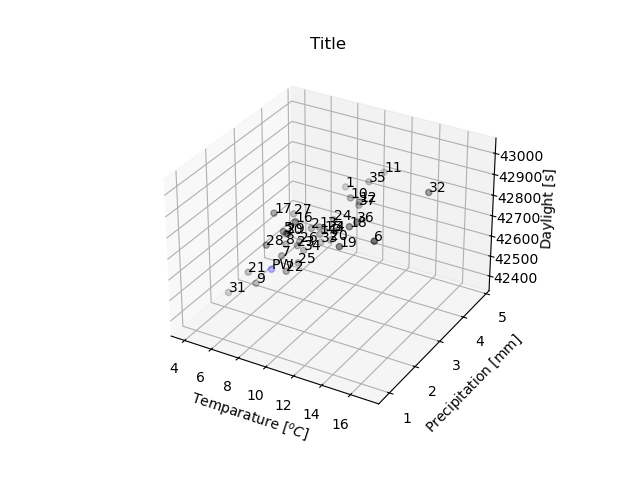

In [81]:
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c=[(0, 0, 0, 0.5)] * len(climate['temp_median'])
c[0] = (0, 0, 1, 0.5)

@interact(use_median_instead_of_mean=False)
def update_plot(use_median_instead_of_mean):
  ax.clear()
  d = '_median'if use_median_instead_of_mean else '_mean'
  ax.scatter(climate['temp' + d], climate['prec' + d], climate['light' + d], c=c)
  for i in range(len(unis)):
    if (i == 0):
      ax.text(climate['temp' + d][i], climate['prec' + d][i], climate['light' + d][i], 'PW')
    else:
      ax.text(climate['temp' + d][i], climate['prec' + d][i], climate['light' + d][i], f"{i}")
  ax.set_title("Climate features per university")
  ax.set_xlabel("Temparature [$^oC$]")
  ax.set_ylabel("Precipitation [$\mathrm{mm}$]")
  ax.set_zlabel("Daylight [$\mathrm{s}$]")

# Air quality comparison

(0.0, 40.0)

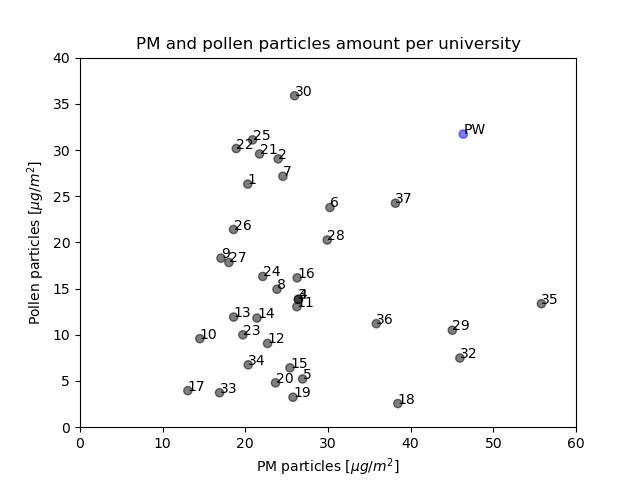

In [47]:
%matplotlib widget
import matplotlib.patches as patches

fig, ax = plt.subplots()

c=[(0, 0, 0, 0.5)] * len(air['pm'])
c[0] = (0, 0, 1, 0.5)
ax.scatter(air['pm'], air['pollen'], c=c)

def plot_2d_uni(i, uni):
  x = air['pm'][i]
  y = air['pollen'][i]
  if (i == 0):
    ax.text(x, y, 'PW')
  else:
    ax.text(x, y, f"{i}")

for i, uni in enumerate(unis):
  plot_2d_uni(i, uni)

ax.set_title("PM and pollen particles amount per university")
ax.set_xlabel("PM particles [$\mu g / m^2$]")
ax.set_ylabel("Pollen particles [$\mu g / m^2$]")
ax.set_xlim([0, 60])
ax.set_ylim([0, 40])

In [55]:
air_df = pd.DataFrame(air)
uni_df = pd.DataFrame(unis)

df = pd.merge(uni_df, air_df, on='id')
df['particle_sum'] = df[['pm', 'pollen']].sum(axis=1)

print("Exchange destinations with lowest average sum of particles")
for ii, (index, row) in enumerate(df.sort_values('particle_sum', ascending=True).head(10).iterrows()):
  print(f"{ii+1}.\t{row['particle_sum']:.2f}  \t{index} - {row['name']} - {row['country']}")

Exchange destinations with lowest average sum of particles
1.	17.00  	17 - Universidad de Burgos - España
2.	20.62  	33 - Glyndŵr University - United Kingdom
3.	24.08  	10 - Ecole Nationale Superieure des Mines d'Ales - France
4.	27.10  	34 - Oxford Brookes University - United Kingdom
5.	28.45  	20 - Hogeschool van Amsterdam - Nederland
6.	29.01  	19 - Universitat Politècnica de Catalunya - España
7.	29.70  	23 - Julius-Maximilians-Universität, Würzburg - Deutschland
8.	30.51  	13 - Université d'Orléans - France
9.	31.75  	12 - Université Bordeaux - France
10.	31.83  	15 - Université Denis Diderot (Paris VII) - France
